In [1]:
import os
from collections import Counter
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import torch
import seaborn as sns
from survkit.train import Trainer
from survkit.utils import get_colors
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

/home/iron-man/Documents/survkit/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import utils
%load_ext autoreload
%autoreload 2
# change to parent directory
%cd ..

/home/iron-man/Documents/survkit


/home/iron-man/Documents/survkit/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
colors = get_colors()
dark_colors = [k for k in colors if 'dark' in k]

In [4]:
colors = get_colors()

# set style for plots
plt.rcParams.update({
    "font.size": 7,
    "axes.linewidth": 0.6,
    "xtick.major.width": 0.6,
    "ytick.major.width": 0.6,
    "xtick.major.size": 2,
    "ytick.major.size": 2,
    "lines.linewidth": 0.6,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})
# use arial font
# manually add the font to the font manager, if needed
set_font = False
if set_font:
    font_dir = os.path.join(os.environ['CONDA_PREFIX'], 'fonts')
    # if envs in path, then split on that and take the first part and join with 'fonts' to get the correct font directory
    if 'envs' in font_dir:
        font_dir = os.path.join(font_dir.split('envs')[0], 'fonts')

    for f in fm.findSystemFonts(fontpaths=[font_dir]):
        fm.fontManager.addfont(f)

plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"

# Top-K of expert routing for groups and summarize patient profiles

In [9]:
def load_model(model_dir, print_num_params=True):
    model_dir = os.path.join(model_dir, 'best')
    model_dict = utils.load_model(model_dir)
    if print_num_params:
        # count model parameters
        num_params = sum(p.numel() for p in model_dict['model'].parameters() if p.requires_grad)
        print(f'Number of parameters: {num_params}')
    return model_dict

def get_model_outputs(model_dict, loader='train'):
    model_outputs = utils.get_model_outputs(model_dict, loader=loader)
    time_bins = model_dict['time_bins'].to('cuda')
    model = model_dict['model']
    train_config = model_dict['train_config']
    trainer = Trainer(train_config, model, optimizer=None, time_bins=time_bins)
    t = model_outputs['t'].to('cuda')
    c = model_outputs['c'].to('cuda')
    t_seq = model_outputs['t_seq'].to('cuda')
    final_logits = model_outputs['final_logits']
    return {**model_outputs, 'trainer': trainer}

In [10]:
model_dict = load_model('models/SUPPORT2/94501e80_SUPPORT2')
model_outputs = get_model_outputs(model_dict, loader='test')
# select the top k experts
k=1
topk_expert_values, topk_expert_indices = torch.topk(model_outputs['expert_scores'], k=k, dim=1)
chosen_experts = torch.zeros_like(model_outputs['expert_scores'])
chosen_experts.scatter_(1, topk_expert_indices, topk_expert_values)

/home/iron-man/Documents/survkit/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/iron-man/Documents/survkit/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/iron-man/Documents/survkit/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


Number of parameters: 62141


100%|██████████| 15/15 [00:00<00:00, 32.77it/s]


tensor([[0.0000, 0.0000, 0.5508,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.3932,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 1.9357, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 1.6544, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 2.1196],
        [0.0000, 0.0000, 0.4396,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')

In [11]:
# let the router define cluster assignments
cluster_assignments = topk_expert_indices.cpu().numpy().flatten()

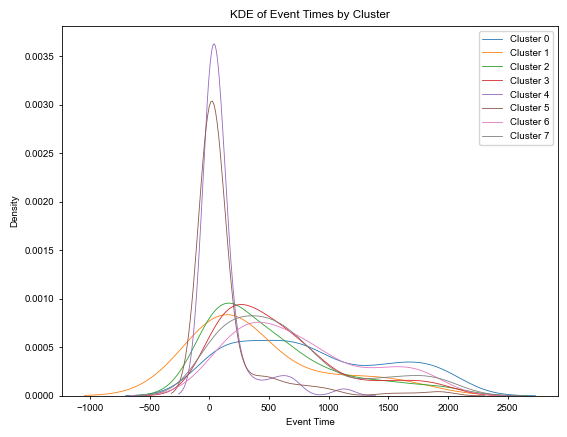

In [12]:
# look at kde of the event time by cluster
for cluster in np.unique(cluster_assignments):
    cluster_indices = np.where(cluster_assignments == cluster)[0]
    cluster_event_times = model_outputs['t'][cluster_indices].cpu().numpy()
    sns.kdeplot(cluster_event_times, label=f'Cluster {cluster}')
plt.xlabel('Event Time')
plt.ylabel('Density')
plt.title('KDE of Event Times by Cluster')
plt.legend()
plt.show()

In [13]:
# breakdown of expert load
expert_load = Counter(topk_expert_indices.cpu().numpy().flatten())
for expert_id, load in expert_load.items():
    print(f'Expert {expert_id}: {load} samples assigned')

Expert 2: 99 samples assigned
Expert 5: 257 samples assigned
Expert 0: 138 samples assigned
Expert 3: 137 samples assigned
Expert 6: 72 samples assigned
Expert 4: 64 samples assigned
Expert 7: 136 samples assigned
Expert 1: 8 samples assigned


In [14]:
analysis_dir = './analysis/support2_routing_analysis'
os.makedirs(analysis_dir, exist_ok=True)

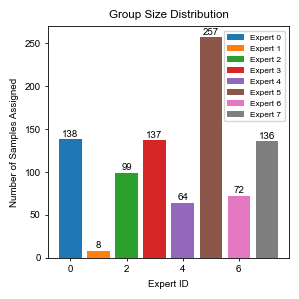

In [15]:
# plot a histogram of the expert assignments colored
fig, ax = plt.subplots(figsize=(3, 3))
for k, v in expert_load.items():
    ax.bar(k, v, color=colors[dark_colors[k]], label=f'Expert {k}')
    # print the number of samples assigned to each expert above the bar
    ax.text(k, v + 0.75, str(v), ha='center', va='bottom', fontsize=7)
ax.set_xlabel('Expert ID')
ax.set_ylabel('Number of Samples Assigned')
plt.title('Group Size Distribution')
# sort the legend by expert id
handles, labels = ax.get_legend_handles_labels()
sorted_handles_labels = sorted(zip(handles, labels), key=lambda x: int(x[1].split()[-1]))
sorted_handles, sorted_labels = zip(*sorted_handles_labels)
ax.legend(sorted_handles, sorted_labels, fontsize=6)
plt.tight_layout()
fig.savefig(os.path.join(analysis_dir, 'expert_load_distribution.pdf'))
fig.savefig(os.path.join(analysis_dir, 'expert_load_distribution.png'))
plt.show()

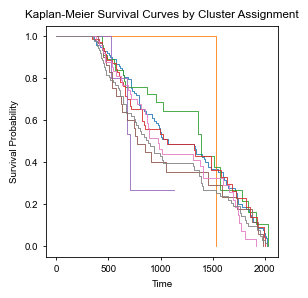

In [16]:
# kaplan-meier survival curves for each cluster assignment
from lifelines import KaplanMeierFitter

fig, ax = plt.subplots(figsize=(3, 3))
kmf = KaplanMeierFitter()
for cluster in np.unique(cluster_assignments):
    cluster_indices = np.where(cluster_assignments == cluster)[0]
    cluster_event_times = model_outputs['t'][cluster_indices].cpu().numpy()
    cluster_event_indicators = model_outputs['c'][cluster_indices].cpu().numpy()
    kmf.fit(cluster_event_times, event_observed=cluster_event_indicators, label=f'Cluster {cluster}')
    kmf.plot_survival_function(ci_show=False, ax=ax, legend=False)
plt.title('Kaplan-Meier Survival Curves by Cluster Assignment')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
# suppress the legend for now, since it is too cluttered
plt.savefig(os.path.join(analysis_dir, 'kaplan_meier_survival_curves_by_cluster.pdf'))
plt.savefig(os.path.join(analysis_dir, 'kaplan_meier_survival_curves_by_cluster.png'))
plt.show()

# Load 5 models to examine the stability of the expert routing assignments across different runs

In [17]:
model_ids = ['94501e80', 'bbe8944b', '58392f55', 'cb6e55ad', '24b84af6']
model_paths = [f'models/SUPPORT2/{model_id}_SUPPORT2' for model_id in model_ids]

In [18]:
cluster_assignments = []
for model_path in model_paths:
    model_dict = load_model(model_path)
    model_outputs = get_model_outputs(model_dict, loader='test')
    # select the top k experts
    k=1
    topk_expert_values, topk_expert_indices = torch.topk(model_outputs['expert_scores'], k=k, dim=1)
    chosen_experts = torch.zeros_like(model_outputs['expert_scores'])
    chosen_experts.scatter_(1, topk_expert_indices, topk_expert_values)
    cluster_assignments.append(topk_expert_indices.cpu().numpy().flatten())

/home/iron-man/Documents/survkit/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/iron-man/Documents/survkit/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/iron-man/Documents/survkit/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


Number of parameters: 62141


100%|██████████| 15/15 [00:00<00:00, 82.63it/s]
/home/iron-man/Documents/survkit/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/iron-man/Documents/survkit/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/iron-man/Documents/survkit/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


Number of parameters: 62141


100%|██████████| 15/15 [00:00<00:00, 83.71it/s]
/home/iron-man/Documents/survkit/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/iron-man/Documents/survkit/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/iron-man/Documents/survkit/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


Number of parameters: 62141


100%|██████████| 15/15 [00:00<00:00, 84.50it/s]
/home/iron-man/Documents/survkit/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/iron-man/Documents/survkit/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/iron-man/Documents/survkit/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


Number of parameters: 62141


100%|██████████| 15/15 [00:00<00:00, 85.62it/s]
/home/iron-man/Documents/survkit/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/iron-man/Documents/survkit/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/iron-man/Documents/survkit/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


Number of parameters: 62141


100%|██████████| 15/15 [00:00<00:00, 82.23it/s]


In [19]:
import numpy as np
from itertools import combinations
from sklearn.metrics import adjusted_rand_score

def clustering_stability(
    assignments_runs,
):
    """
    Parameters
    ----------
    assignments_runs : list of array-like, each length N
        Cluster labels for each run (label identities can differ across runs).
    """
    runs = [np.asarray(a) for a in assignments_runs]
    N = len(runs[0])
    assert all(len(r) == N for r in runs), "All runs must have the same N."

    # pairwise ARI across runs
    aris = [adjusted_rand_score(r1, r2) for r1, r2 in combinations(runs, 2)]
    mean_ari = float(np.mean(aris))
    std_ari = float(np.std(aris, ddof=1)) if len(aris) > 1 else 0.0

    out = {
        "aris": aris,
        "mean_ari": mean_ari,
        "std_ari": std_ari,
    }

    return out

In [21]:
# runs = [labels_run0, labels_run1, labels_run2, labels_run3, labels_run4]
report = clustering_stability(cluster_assignments)
print({
  "mean_ari": report["mean_ari"],
})

{'mean_ari': 0.4247426597939821}


In [22]:
report['aris']

[0.4221954630632978,
 0.40325646036174784,
 0.3777068125295814,
 0.3664199496320451,
 0.4370691076072622,
 0.5200076517391874,
 0.4506366484667542,
 0.40742055227079405,
 0.39902466402577974,
 0.4636892882433705]